### New file

In [27]:
# %matplotlib inline

# import io, os, sys, types
# from IPython import get_ipython
# from nbformat import read
# from IPython.core.interactiveshell import InteractiveShell


import math
import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.cm as cmx
import os

In [28]:
distros = ['mix', 'gau_1', 'gau_2', 'exp']
stepsizes = ['const', '2_div_sqrt_k', '0.002_div_sqrt_k']

tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]
N_g = 12 # N_generation
N_s = 10 # N_shuffle

N_q = len(tau_vals)

# c_Norm = colors.Normalize(vmin=0, vmax=1)
# scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))

In [29]:
main_fd = 'Experiment_results/'
fd_lst = ['Frugal_SGD', 'SGD']
for fd in fd_lst:
    if not os.path.exists(main_fd+fd):
        os.makedirs(main_fd+fd)
        
sgd_lst = ['distro', 'data_size', 'step_size', 'data_sequence']        
for fd in sgd_lst:
    fd_name = main_fd+'SGD/'+fd
    if not os.path.exists(fd_name):
        os.makedirs(fd_name)

In [30]:
def get_settings(distro_lst, datasize_lst, stepsize_lst):
    len_lst = [len(distro_lst), len(datasize_lst), len(stepsize_lst)]
    if len_lst.count(1) != len(len_lst)-1: raise Exception("Setting inputs are wrong!")
    
    N_settings = max((len_lst))
    setting_lst = []
    for lst in [distro_lst, datasize_lst, stepsize_lst]:
        if len(lst)==1: 
            lst = lst*N_settings
        setting_lst.append(lst)
        
    changed_setting = None
    if len(distro_lst)>1:
        changed_setting = 'distro'
    elif len(datasize_lst)>1:
        changed_setting = 'data_size'
    elif len(stepsize_lst)>1:
        changed_setting = 'step_size'
    return np.asarray(setting_lst).T, changed_setting


In [31]:
def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau_1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau_2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)*6.5 - 20
    else: raise Exception("distribution doesn't work!")

In [32]:
def get_dataset(distro, datasize, g_test=False):
    if g_test:
        dataset = np.zeros((N_g, datasize))
        for i in range(N_g):
            dataset[i] = get_one_dt(distro, datasize)
    else:
        dataset = get_one_dt(distro, datasize)
    return dataset

In [33]:
def get_q_true(distro, tau_lst):
    if tau_lst == tau_vals:
        if distro=='gau_1':
            return np.asarray([-21.06792817980280840537, 
                              -7.43920922874473411269,
                              2,
                              25.06792817980280840537,
                              43.87426173273513981594])
        elif distro=='gau_2':
            return np.asarray([-0.001281551565544600466965,
                              -5.244005127080407840383E-4,
                              0,
                              0.001281551565544600466965,
                              0.002326347874040841100886])
        elif distro=='mix':
            # sampled from 100000000 datapoints
            return np.asarray([-80.28496182,
                               -29.02324254,
                               -0.36011575,
                               36.69268923,
                               120.7676231])
        elif distro=='exp':
            return np.asarray([0.1053605156578263012275,
                              0.3566749439387323789126,
                              0.6931471805599453094172,
                              2.302585092994045684018,
                              4.605170185988091368036])*6.5 - 20
    raise Exception('tau_lst should be tau_vals')
    

In [34]:
def get_q_batch(dataset, tau_lst):
    if len(dataset.shape) != 1:
        raise Exception('Dataset for q_batch calculation of wrong shape: ' + str(dataset.shape))
        
    q_batch = np.zeros(len(tau_lst))
    for i, tau in enumerate(tau_lst):
        q_batch[i] = np.percentile(dataset, tau*100)
    return q_batch

In [35]:
def get_q_batches(dataset, tau_lst):
    # g_test = False
    if len(dataset.shape) == 1: 
        return get_q_batch(dataset, tau_lst)
    else:
        q_batches = np.zeros((dataset.shape[0], len(tau_lst)))
        for i in range(q_batches.shape[0]):
            q_batches[i] = get_q_batch(dataset[i], tau_lst)
    return q_batches

In [44]:
def set_stepsize(k, stepsize, length):
    if stepsize=='const':
        return 1 * np.ones(length)
    elif stepsize=='2_div_sqrt_k':
        return 2/math.sqrt(k)* np.ones(length)
    elif stepsize=='0.002_div_sqrt_k':
        return 0.002/math.sqrt(k) * np.ones(length)
    raise Exception('stepsize parameter is wrong')

In [57]:
def get_procs(dataset, step_size, tau_lst):
    update_size = 200
    proc = np.zeros((dataset.shape[0], len(tau_lst)))
    q_pre, q_arr = np.zeros(len(tau_lst)), np.zeros(len(tau_lst))
    alpha_adaptation = np.ones(len(tau_lst))

    for k, x in enumerate(dataset):          
        if k % update_size == 0 and k >0:
#             print (k,q_arr-q_pre)
            update_var = update_stepsize(alpha_arr, q_arr-q_pre, step_size, update_size)
#             print ('update_var', update_var)
            alpha_adaptation = alpha_adaptation * update_var
#             print ('alpha_adaptation', alpha_adaptation)
            q_pre = [i for i in q_arr]
        if step_size != 'frugal': 
            alpha_arr = set_stepsize(k+1, step_size, len(tau_lst))* alpha_adaptation
#             if k % update_size == 0: print('alpha_arr', alpha_arr)
        for i, q in enumerate(q_arr):
            tau = tau_lst[i]
            alpha = alpha_arr[i]
            if step_size != 'frugal':
                q = sgd(q, x, tau, alpha)
            else: 
                q = frugal(q, x, tau)
            q_arr[i] = q
        proc[k] = q_arr
#     print (alpha_arr)
    return proc.T
   
# def set_stepsize(idx, step_size, len_arr):
#     return np.ones(len_arr)*10


def update_stepsize(alpha_arr, diff, step_size, update_size):
    update_var = np.ones(len(diff))
    for i, a in enumerate(alpha_arr):
        d = diff[i]
        if a * update_size * 0.4 < abs(d): update_var[i] = 2
        elif d == 0: update_var[i] = 1/2
#     print ('step_size', update_var)
    return update_var
    
def sgd(q, x, tau, alpha):
    if x > q:
        q = q + alpha*tau
    else:
        q = q - alpha*(1-tau)  
    return q
    
def frugal(q, x, tau):
    rdn = np.random.uniform()
    if x > q and rdn > 1-tau:
        q += 1
    elif x < q and rdn > tau:
        q -= 1
    return q

In [58]:
# def get_procs(dataset, step_size, tau_lst):
#     if len(dataset.shape)!= 1: 
#         raise Exception('Dataset for get_procs() of wrong shape:' + str(dataset.shape)+ ', should be 1d array')
        
#     procs = np.zeros((len(tau_lst), dataset.shape[0]))
#     for idx, tau in enumerate(tau_lst):
#         q = 0
#         q_sgd_proc = procs[idx]
#         # change stepsize
#         if step_size != 'frugal':
#             for k, x in enumerate(dataset):
# #                 if idx==1: print (k, ':', q)
#                 alpha = set_stepsize(k+1, step_size)
#                 if x > q:
#                     q = q + alpha*tau
#                 else:
#                     q = q - alpha*(1-tau)
#                 q_sgd_proc[k] = q
        
#         # frugal
#         else:
#             rdn_lst = np.random.uniform(0,1, dataset.shape[0])
#             for k, x in enumerate(dataset):
#                 rdn = rdn_lst[k]
#                 if x > q and rdn > 1-tau:
#                     q += 1
#                 elif x < q and rdn > tau:
#                     q -= 1
#                 q_sgd_proc[k] = q
#     return procs

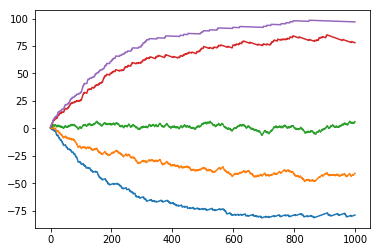

In [59]:
dataset = np.random.uniform(-100, 100, 1000)
proc = get_procs(dataset, 'const', tau_vals)
# print(proc[1])
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(proc.T)

In [60]:
def get_res(procs):
    if len(procs.shape)!=2:raise Exception('Procs of wrong shape:' + str(procs.shape)+ ', should be 2d array')
    return procs[:, -1]

In [61]:
def get_q_ests(dataset, step_size, tau_lst):

    if len(dataset.shape)>2:
        raise Exception('Dataset for q_est calculation of wrong shape:' + str(dataset.shape)+ ', should be 1d or 2d array')
    if len(dataset.shape)==1:
        procs = get_procs(dataset, step_size, tau_lst)
        res = get_res(procs)
    else:
        res = np.zeros((dataset.shape[0], len(tau_lst)))
        procs = np.zeros((dataset.shape[0], len(tau_lst), dataset.shape[1]))
        for idx, dt in enumerate(dataset):
            procs[idx] = get_procs(dt, step_size, tau_lst)
            res[idx] = get_res(procs[idx])
    return res, procs

In [62]:
# dataset = get_dataset('gau_1', 1000, g_test=True) * 50 - 200
# print(dataset.shape)

# # proc1 = get_procs(dataset, 'const', tau_vals)
# ## res1 = get_res(proc1)
# # proc2 = get_procs(dataset, 'frugal', tau_vals)
# # plt.plot(proc1.T)ad
# # plt.plot(proc2.T)
# # plt.show()


# res, proc = get_q_ests(dataset, 'const', tau_vals)
# print(res)
# print(proc)

In [63]:
def get_normalized_e(true, batches, est):
    upper = est - batches
    bottom = true - batches
    return (upper/bottom)

### Export data

In [64]:
def write_data(data, filename, setting=None):
    with open(filename, 'w') as outfile:
        if setting is not None: outfile.write('# Setting: {0}\n'.format(setting))
        if len(data.shape) == 1: data = data.reshape(-1, 1)
        outfile.write('# Array shape: {0}\n \n'.format(data.shape))

        for data_slice in data:
            np.savetxt(outfile, data_slice, fmt='%-15.8g')
            outfile.write('\n')


def write_data_overview(category, setting, tau_lst, file_name):
    with open(file_name, 'w') as f:
        f.write("Tested on "+category+": "+str(setting)+"\n") 
        f.write(str(tau_lst))
    
# write_data_overview('ca', 'se', tau_vals, "try.txt")
    
def save_data(foldername, file_name, tau_lst, data_dict):
    category, setting = file_name[0], file_name[1]    
    write_data_overview(category, setting, tau_lst, foldername+str(setting)+"_"+"overview.txt")

    for data_name in data_dict:
        print (foldername+str(setting)+"_"+data_name+'.txt')
        write_data(data_dict[data_name], foldername+str(setting)+"_"+data_name+'.txt')
        
    return

# save_data('', ('C', 'S'), tau_vals, {'dataset': np.reshape(np.random.uniform(0, 4, 100), (2, 5, 10))})

### Main functions 

In [65]:
def get_file_name(changed_setting, distro, datasize, stepsize, s_test):
#     print(changed_setting)
    if s_test:
        return ('Shuffle', True)
    elif changed_setting=='distro':
        return ('Distribution', distro)
    elif changed_setting=='data_size':
        return ('Data size', datasize)
    elif changed_setting=='step_size':
        return ('Step size', stepsize)
    else: raise Exception ('Cannot get file name')

In [66]:
def quantile_sgd_compare(folder_name, distro_lst, datasize_lst, stepsize_lst, 
                         g_test=False, s_test=False, tau_lst=tau_vals, 
                        ):
    
    if g_test and s_test: raise Exception("g_test and s_test can't both be true")
    
    # generate different settings
    setting_lst, changed_setting = get_settings(distro_lst, datasize_lst, stepsize_lst,)
    print (setting_lst)
    # if only stepsize changes, generate dataset and q_batches
    dataset, q_batches = 0, 0
    if changed_setting=='step_size':
        dataset = get_dataset(distro_lst[0], datasize_lst[0], g_test)
        q_batches = get_q_batches(dataset, tau_lst)
        
    # for each setting = [distro, datasize, stepsize]
    for idx, setting in enumerate(setting_lst):
        
        # generate all the data
        distro, datasize, stepsize = setting[0], int(setting[1]), setting[2]
        q_true = get_q_true(distro, tau_lst)
        if changed_setting != 'step_size':
            dataset = get_dataset(distro, datasize, g_test)
            q_batches = get_q_batches(dataset, tau_lst)
        if s_test:
            shuffled_dt = np.zeros((N_s, datasize))
            for i in range(N_s):
                np.random.shuffle(dataset)
                shuffled_dt[i] = dataset
            dataset = shuffled_dt
        q_est_res, q_est_proc = get_q_ests(dataset, stepsize, tau_lst)
        E = get_normalized_e(q_true, q_batches, q_est_res)
        
        data_dict = {
            'q_true': q_true,
            'q_batches': q_batches,
            'q_est_res': q_est_res,
            'q_est_proc': q_est_proc,
            'E': E
        }
#         print(E)
#         # generate charts and tables?
        file_name = get_file_name(changed_setting, distro, datasize, stepsize, s_test)
        save_data(folder_name, file_name, tau_lst, data_dict)

In [67]:
# sgd_lst = ['distro', 'data_size', 'step_size', 'data_sequance']        

def all_sgd_comparisons():
    for t in sgd_lst:
        print (t)
        folder_name = "Experiment_results/SGD/"+t+"/"
        if t=='distro':
            quantile_sgd_compare(folder_name, distros, [1000], ['const'], True)
        elif t=='data_size':
            quantile_sgd_compare(folder_name, ['gau_1'], [100, 1000, 100000], ['const'], True)
        elif t=='step_size':
            quantile_sgd_compare(folder_name, ['gau_1'], [1000], stepsizes, True)
        elif t=='data_sequence':
            quantile_sgd_compare(folder_name, ['gau_1', 'gau_1'], [1000], ['const'], False, True)
            

In [68]:
# Run all functions
all_sgd_comparisons()

distro
[['mix' '1000' 'const']
 ['gau_1' '1000' 'const']
 ['gau_2' '1000' 'const']
 ['exp' '1000' 'const']]
Experiment_results/SGD/distro/mix_q_true.txt
Experiment_results/SGD/distro/mix_q_batches.txt
Experiment_results/SGD/distro/mix_q_est_res.txt
Experiment_results/SGD/distro/mix_q_est_proc.txt
Experiment_results/SGD/distro/mix_E.txt
Experiment_results/SGD/distro/gau_1_q_true.txt
Experiment_results/SGD/distro/gau_1_q_batches.txt
Experiment_results/SGD/distro/gau_1_q_est_res.txt
Experiment_results/SGD/distro/gau_1_q_est_proc.txt
Experiment_results/SGD/distro/gau_1_E.txt
Experiment_results/SGD/distro/gau_2_q_true.txt
Experiment_results/SGD/distro/gau_2_q_batches.txt
Experiment_results/SGD/distro/gau_2_q_est_res.txt
Experiment_results/SGD/distro/gau_2_q_est_proc.txt
Experiment_results/SGD/distro/gau_2_E.txt
Experiment_results/SGD/distro/exp_q_true.txt
Experiment_results/SGD/distro/exp_q_batches.txt
Experiment_results/SGD/distro/exp_q_est_res.txt
Experiment_results/SGD/distro/exp_q_est_p

In [ ]:
# def sgd_frugal_compare(distro_lst, datasize, tau_lst=tau_vals):
#     #distro changes, use the biggest datasize, do not shuffle
#     for distro in distro_lst:
#         q_true = get_q_true(distro, tau_lst)
#         dataset = get_dataset(distro, datasize, False)
#         q_batches = get_q_batches(dataset, tau_lst)
        
#         sgd_res, sgd_proc = get_q_ests(dataset, 'const', tau_lst)
        
#         N_frugal = 20
#         frugal_res = np.zeros((N_frugal, len(tau_lst)))
#         frugal_proc = np.zeros((N_frugal, len(tau_lst), datasize))
#         for i in range(N_frugal):
#             frugal_res[i], frugal_proc[i] = get_q_ests(dataset, 'frugal', tau_lst)
        
#         ax_name = 'Tested on '+distro+' distritbution with '+str(datasize)+' data points'
#         fig, lgd = plot_procs(ax_name, tau_vals, q_true, frugal_proc, sgd_proc)
#         title = fig.suptitle('Quantile Estimation: Frugal vs SGD')

#         fd = "Experiment_results/Frugal_SGD/"
#         plt.savefig(fd+distro+'.png', bbox_extra_artists=(lgd, title), bbox_inches='tight')
        
        
# sgd_frugal_compare(distros, 1000)

<!---
### Always have $q_k = x$ for each x in the data stream

When $x - q_k > 0$, we have $l(q_k) = \tau(x-q_k)$:
\begin{align}
q_{k+1} & = q_k - \frac{l(q_k)}{l'(q_k)} \\
        & = q_k - \frac{\tau(x-q_k)}{-\tau} \\
        & = q_k - (- x + q_k) \\
        & = x
\end{align}

Same happens when $x - q_k < 0$
-->